<Axes: >

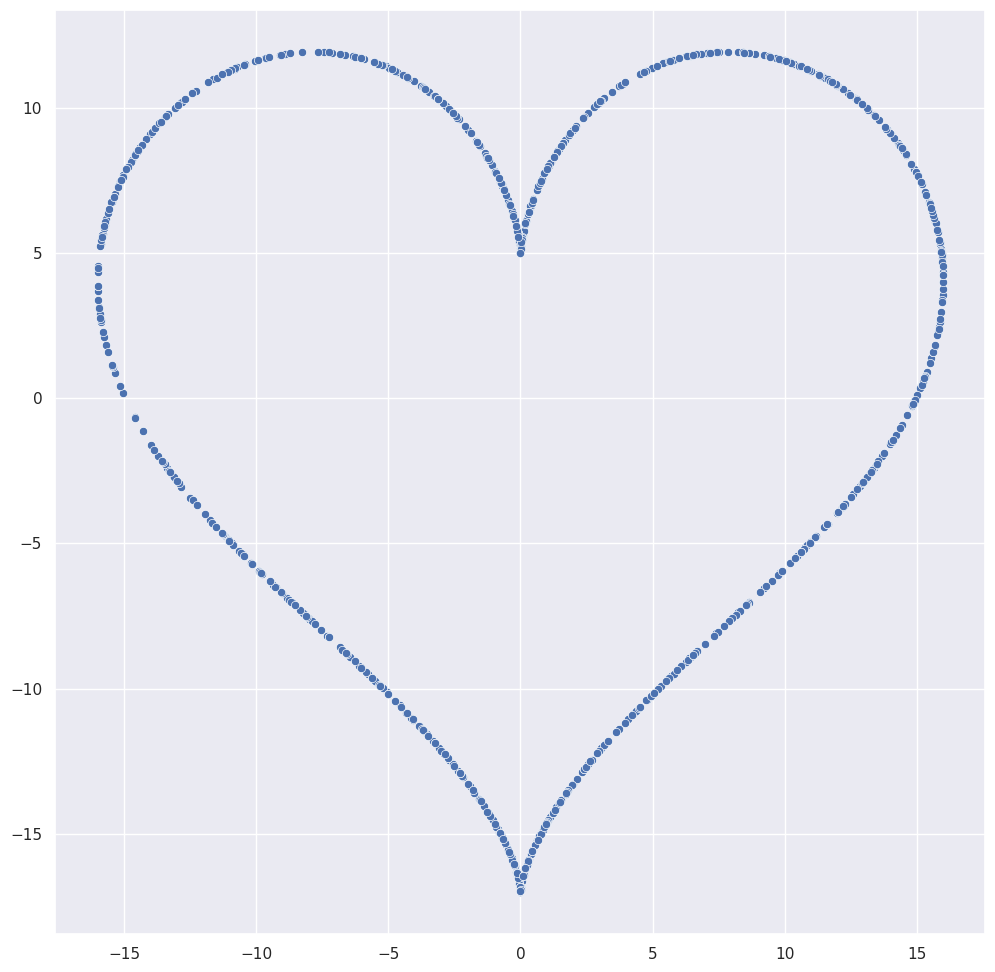

In [1]:
#%% packages
import torch
from torch.utils.data import DataLoader
from torch import nn

import math
import matplotlib.pyplot as plt
import numpy as np
from random import uniform

import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})
#%% create training data
TRAIN_DATA_COUNT = 1024
theta = np.array([uniform(0, 2 * np.pi) for _ in range(TRAIN_DATA_COUNT)]) # np.linspace(0, 2 * np.pi, 100)
# Generating x and y data
x = 16 * ( np.sin(theta) ** 3 )
y = 13 * np.cos(theta) - 5 * np.cos(2*theta) - 2 * np.cos(3*theta) - np.cos(4*theta)
sns.scatterplot(x=x, y=y)


In [2]:

#%% prepare tensors and dataloader
train_data = torch.Tensor(np.stack((x, y), axis=1))
train_data

tensor([[ -3.5354, -11.5810],
        [ -2.4266,   9.7019],
        [ -6.0509,  -9.2617],
        ...,
        [  5.0533, -10.1447],
        [  0.1890,   6.0269],
        [ -5.3082,  -9.9158]])

In [3]:
train_labels = torch.zeros(TRAIN_DATA_COUNT)

train_labels

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [5]:


#  dataloader
BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


In [6]:
#%% initialize discriminator and generator
discriminator = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

generator = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )



1000
Epoch 1000, Discriminator Loss 0.405048668384552
Epoch 1000, Generator Loss 1.1299467086791992


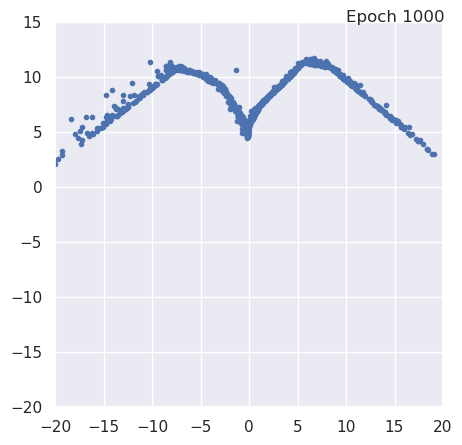

2000
Epoch 2000, Discriminator Loss 0.5266804099082947
Epoch 2000, Generator Loss 1.1096011400222778


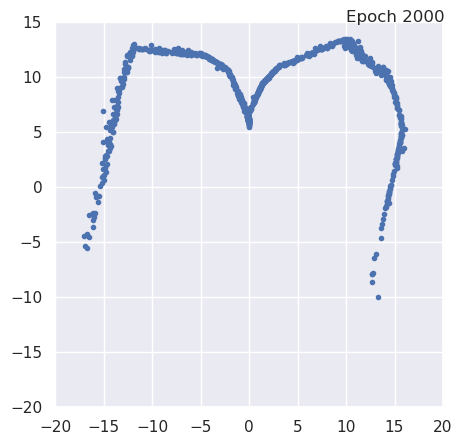

3000
Epoch 3000, Discriminator Loss 0.5985946655273438
Epoch 3000, Generator Loss 1.0228079557418823


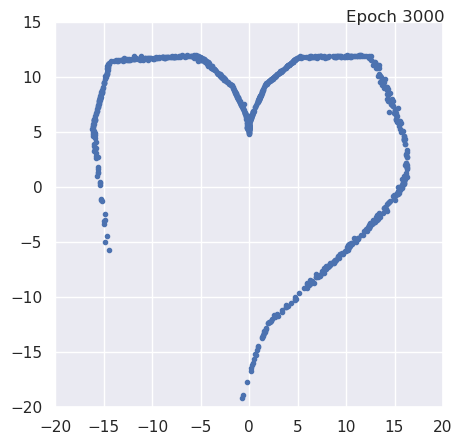

4000
Epoch 4000, Discriminator Loss 0.6453732252120972
Epoch 4000, Generator Loss 0.8406837582588196


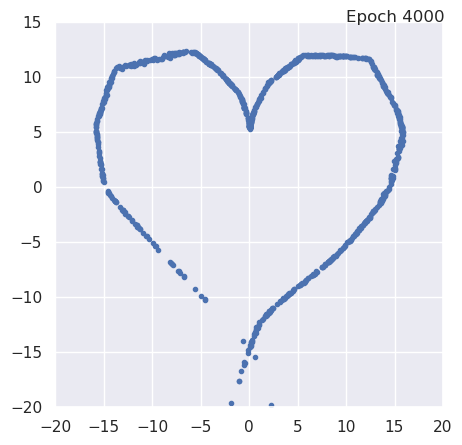

5000
Epoch 5000, Discriminator Loss 0.6170738339424133
Epoch 5000, Generator Loss 0.8470122814178467


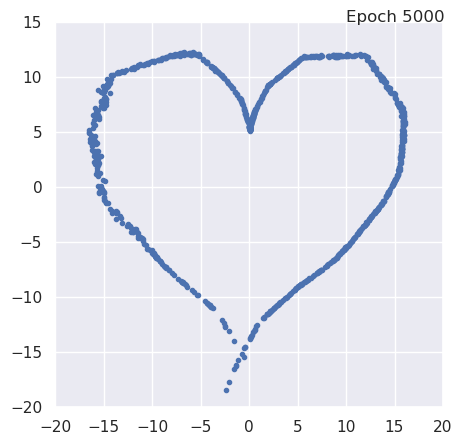

6000
Epoch 6000, Discriminator Loss 0.6270612478256226
Epoch 6000, Generator Loss 0.7585588097572327


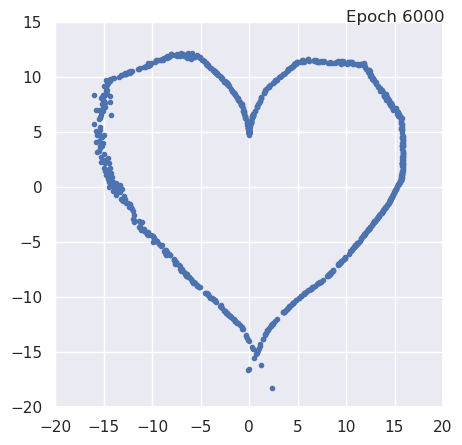

7000
Epoch 7000, Discriminator Loss 0.668510913848877
Epoch 7000, Generator Loss 0.733921468257904


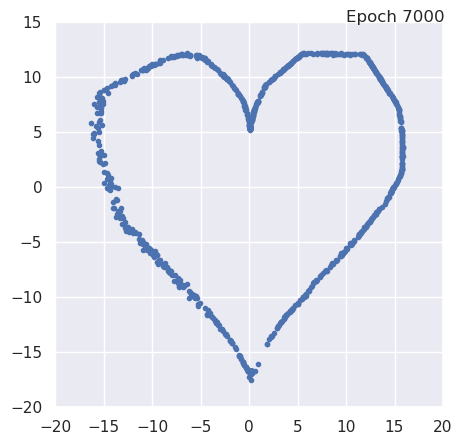

8000
Epoch 8000, Discriminator Loss 0.6946251392364502
Epoch 8000, Generator Loss 0.7011975049972534


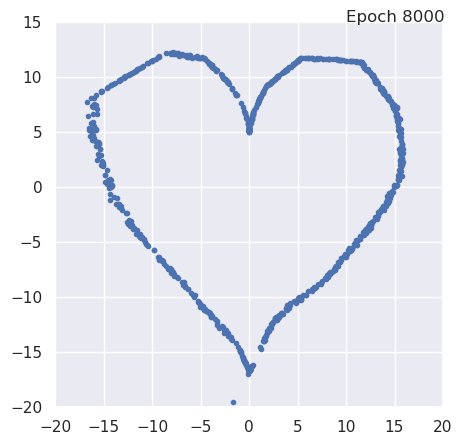

9000
Epoch 9000, Discriminator Loss 0.6800927519798279
Epoch 9000, Generator Loss 0.7540242075920105


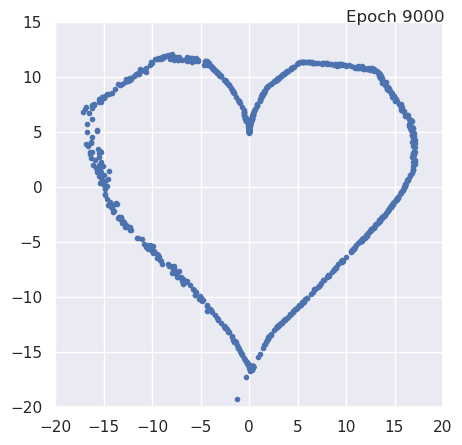

10000
Epoch 10000, Discriminator Loss 0.622160792350769
Epoch 10000, Generator Loss 0.8035207986831665


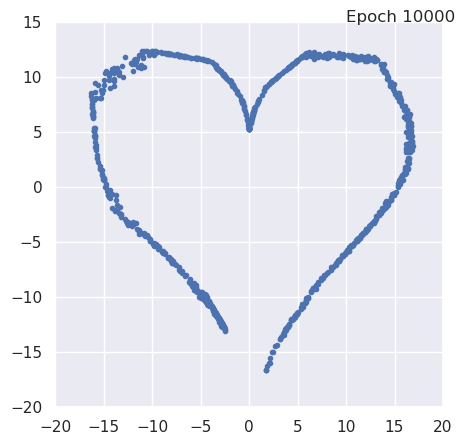

11000
Epoch 11000, Discriminator Loss 0.669502854347229
Epoch 11000, Generator Loss 0.8105546236038208


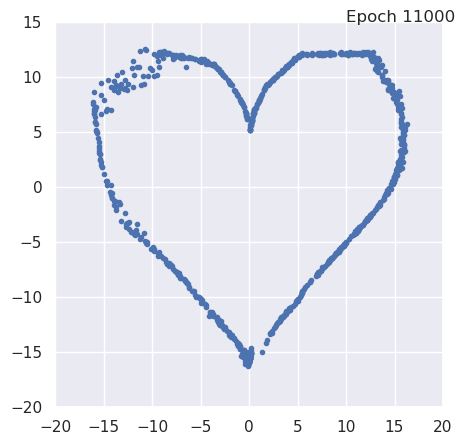

12000
Epoch 12000, Discriminator Loss 0.6596097350120544
Epoch 12000, Generator Loss 0.8522567749023438


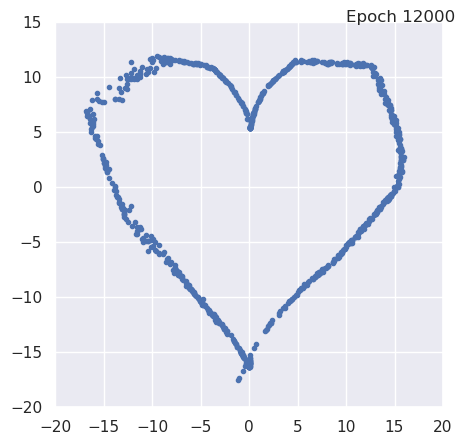

KeyboardInterrupt: 

In [7]:
# %% training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LR = 1e-5
NUM_EPOCHS = 20000
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters())
optimizer_generator = torch.optim.Adam(generator.parameters())

discriminator.to(device)
generator.to(device)

for epoch in range(NUM_EPOCHS):
    for n, (real_samples, _) in enumerate(train_loader):
        real_samples = real_samples.to(device)
        # Data for training the discriminator
        real_samples_labels = torch.ones((BATCH_SIZE, 1)).to(device)
        latent_space_samples = torch.randn((BATCH_SIZE, 2)).to(device)

        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((BATCH_SIZE, 1)).to(device)
        
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        if epoch % 2 == 0:
            # Training the discriminator
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(
                output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()

        if epoch % 2 == 1:
            # Data for training the generator
            latent_space_samples = torch.randn((BATCH_SIZE, 2)).to(device)

            # Training the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(
                output_discriminator_generated, real_samples_labels
            )
            loss_generator.backward()
            optimizer_generator.step()
    
    # Show progress
    if epoch % 1000 == 0 and epoch !=0 :
        print(epoch)
        print(f"Epoch {epoch}, Discriminator Loss {loss_discriminator}")
        print(f"Epoch {epoch}, Generator Loss {loss_generator}")
        with torch.no_grad():
            latent_space_samples = torch.randn(1000, 2).to(device)
            generated_samples = generator(latent_space_samples).detach().cpu()
        plt.figure(figsize=(5, 5))
        plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
        plt.xlim((-20, 20))
        plt.ylim((-20, 15))
        plt.text(10, 15, f"Epoch {epoch}")
        plt.show()
